In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

from ionpy.analysis import ResultsLoader
from ese.experiment.experiment import CalibrationExperiment
import seaborn as sns
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
os.environ["CUDA_VISIBLE_DEVICES"] = '1' 

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

In [2]:
# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [3]:
path = f"{root}/WMH_aug_runs"

dfc = rs.load_configs(
    path,
    properties=False,
)

df = rs.load_metrics(dfc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
best_exp = rs.get_experiment(
    df=df,
    exp_class=CalibrationExperiment,
    metric="val-dice_score",
    checkpoint="max-val-dice_score",
    device="cuda"
)

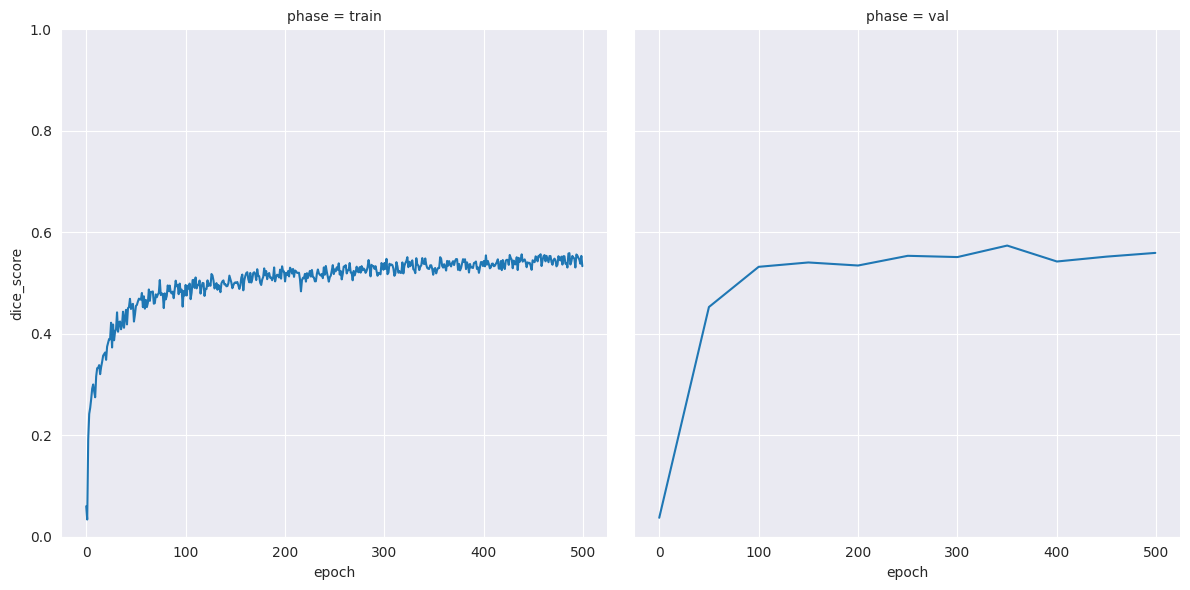

In [5]:
best_exp.vis_loss_curves(height=6)

In [6]:
%%yaml dataset_cfg 

_class: ese.experiment.datasets.WMH
annotator: observer_o12
axis: 0
split: cal 
num_slices: 1
slicing: midslice 
task: Amsterdam 
version: 0.2

<IPython.core.display.Javascript object>

In [7]:
from ionpy.experiment.util import absolute_import
from torch.utils.data import DataLoader

dataset_cls = absolute_import(dataset_cfg.pop("_class"))
WMH_Dataset = dataset_cls(**dataset_cfg)
wmh_dataloader = DataLoader(WMH_Dataset, batch_size=1, shuffle=False, drop_last=False)

In [8]:
import torch
import einops
from tqdm.notebook import tqdm
from ese.experiment.metrics.grouping.portion_loss import accuracy_vs_boundary_dist, accuracy_vs_instancesize, accuracy_vs_label
from ionpy.util.torchutils import to_device

def get_dataset_perf(
        exp, 
        dataloader, 
        ):

    items = []
    with torch.no_grad():
        for _, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
            # Get your image label pair and define some regions.
            x, y = to_device(batch, exp.device)
            # Reshape to a good size
            x = einops.rearrange(x, "b c h w -> (b c) 1 h w")
            y = einops.rearrange(y, "b c h w -> (b c) 1 h w")
            # Get the prediction
            yhat = exp.model(x)  
            # Extract predictions
            soft_pred = torch.sigmoid(yhat)
            # Get the hard prediction
            hard_pred = (soft_pred > 0.5).float()
            # Squeeze our tensors
            x = x.squeeze().cpu().numpy()
            y = y.squeeze().cpu().numpy()
            soft_pred = soft_pred.squeeze().cpu().numpy()
            hard_pred = hard_pred.squeeze().cpu().numpy()
            # Get some performance metrics
            perf_per_label = accuracy_vs_label(
                y_pred=hard_pred, 
                y_true=y
                )
            perf_per_dist = accuracy_vs_boundary_dist(
                y_pred=hard_pred,
                y_true=y
                )
            perf_per_regsize = accuracy_vs_instancesize(
                y_pred=hard_pred, 
                y_true=y
                )
            # Wrap it in an item
            items.append({
                "image": x,
                "label_map": y,
                "conf_map": soft_pred,
                "pred_map": hard_pred,
                "perf_per_dist": perf_per_dist,
                "per_per_label": perf_per_label,
                "perf_per_regsize": perf_per_regsize,
            })
    return items

In [9]:
# val_perf is a dict where each item is the subj id
# with the y, ypred, yloss, ydice
predictions_list = get_dataset_perf(
    exp=best_exp, 
    dataloader=wmh_dataloader
    )

  0%|          | 0/7 [00:00<?, ?it/s]